# Tutorial 2: ATAC-RNA-Seq Mouse Brain RNA and ATAC Multi-Omics Data

We applied COSMOS to analyze a spatially resolved multi-omics dataset based on real-world experiments instead of simulated data. This experimental dataset contains P22 mouse brain coronal sections with a joint profiling of spatial chromatin accessibility (ATAC) and spatial transcriptome (RNA). The annotation was manually generated by aligning the sample with the P56 mouse brain coronal section from Allen Mouse Brain Atlas.

The raw data can be downloaded from: 
https://brain-spatial-omics.cells.ucsc.edu

The processed data is available at: https://zenodo.org/records/13932144

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
from COSMOS import cosmos
from COSMOS.pyWNN import pyWNN 
import h5py
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

/Applications/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  Preparation of data

### Importing the data

In [2]:
data_mat = h5py.File('./ATAC_RNA_Seq_MouseBrain_RNA_ATAC.h5', 'r')
df_data_RNA = np.array(data_mat['X_RNA']).astype('float64')     # gene count matrix
df_data_ATAC= np.array(data_mat['X_ATAC']).astype('float64')  # protein count matrix
loc = np.array(data_mat['Pos']).astype('float64') 
LayerName = list(data_mat['LayerName'])
LayerName = [item.decode("utf-8") for item in LayerName]

adata1 = sc.AnnData(df_data_RNA, dtype="float64")
adata1.obsm['spatial'] = np.array(loc)
adata1.obs['LayerName'] = LayerName
adata1.obs['x_pos'] = np.array(loc)[:,0]
adata1.obs['y_pos'] = np.array(loc)[:,1]

adata2 = sc.AnnData(df_data_ATAC, dtype="float64")
adata2.obsm['spatial'] = np.array(loc)
adata2.obs['LayerName'] = LayerName
adata2.obs['x_pos'] = np.array(loc)[:,0]
adata2.obs['y_pos'] = np.array(loc)[:,1]

### Visualizing spatial positions with annotation

(-4.95, 103.95, -2.8500000000000005, 103.85)

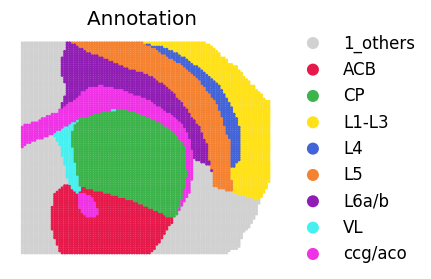

In [3]:
adata_new = adata1.copy()
adata_new.obs["LayerName"]=adata_new.obs["LayerName"].astype('category')


matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(3.5,3))
sz = 20
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Annotation ' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')

## Applying COSMOS to integrate RNA and ATAC omics

In [4]:
## COSMOS training 
cosmos_comb = cosmos.Cosmos(adata1=adata1,adata2=adata2)
cosmos_comb.preprocessing_data(n_neighbors = 10)
cosmos_comb.train(spatial_regularization_strength=0.01, z_dim=50, 
         lr=1e-3, wnn_epoch = 500, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)
weights = cosmos_comb.weights
df_embedding = pd.DataFrame(cosmos_comb.embedding)

Epoch 1/1000, Loss: 1.4096118211746216
Epoch 11/1000, Loss: 1.1203821897506714
Epoch 21/1000, Loss: 0.7638721466064453
Epoch 31/1000, Loss: 0.4149342179298401
Epoch 41/1000, Loss: 0.17488263547420502
Epoch 51/1000, Loss: 0.06789164245128632
Epoch 61/1000, Loss: 0.0332467220723629
Epoch 71/1000, Loss: 0.02090390771627426
Epoch 81/1000, Loss: 0.01618310436606407
Epoch 91/1000, Loss: 0.012922131456434727
Epoch 101/1000, Loss: 0.010959653183817863
Epoch 111/1000, Loss: 0.010975166223943233
Epoch 121/1000, Loss: 0.008905645459890366
Epoch 131/1000, Loss: 0.009921539574861526
Epoch 141/1000, Loss: 0.008092425763607025
Epoch 151/1000, Loss: 0.007676845416426659
Epoch 161/1000, Loss: 0.007937170565128326
Epoch 171/1000, Loss: 0.00713766273111105
Epoch 181/1000, Loss: 0.006691939663141966
Epoch 191/1000, Loss: 0.006564016919583082
Epoch 201/1000, Loss: 0.0060991630889475346
Epoch 211/1000, Loss: 0.005894108675420284
Epoch 221/1000, Loss: 0.005854759365320206
Epoch 231/1000, Loss: 0.006449344567

### Clustering of COSMOS integration

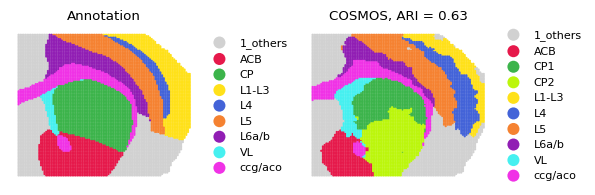

In [5]:
adata_new = adata1.copy()
embedding_adata = sc.AnnData(df_embedding)
sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')

# Manualy setting resolution for clustering
res = 1.0
sc.tl.louvain(embedding_adata, resolution=res)
adata_new.obs['Cluster_cosmos'] = list(embedding_adata.obs["louvain"].cat.codes)
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')

# Relabeling clusters with layer names
digit_labels = list(adata_new.obs['Cluster_cosmos'])
for i in range(len(digit_labels)):
    if digit_labels[i] not in [0,1,2,4,5,6,7,8,11]:
        digit_labels[i] = 100
adata_new.obs['Cluster_cosmos'] = digit_labels
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')
adata_new.obs['Cluster_cosmos'].cat.rename_categories({0: 'CP2',
                                                   1: 'L5',
                                                   2: 'CP1',
                                                   4: 'L4',
                                                   5: 'ccg/aco',
                                                   6: 'ACB',
                                                   7: 'L1-L3',
                                                    8: 'L6a/b',
                                                   11: 'VL',
                                                    100: '1_others'
                                                         }, inplace=True)

ordered_cluster = np.unique(list(adata_new.obs['Cluster_cosmos']))
adata_new.obs['Cluster_cosmos'] = adata_new.obs['Cluster_cosmos'].cat.reorder_categories(ordered_cluster, ordered=True)

# Calculating ARI
opt_cluster_cosmos = list(adata_new.obs['Cluster_cosmos'])
opt_ari_cosmos = sklearn.metrics.adjusted_rand_score(LayerName, opt_cluster_cosmos)
opt_ari_cosmos = round(opt_ari_cosmos, 2)

# Ploting figures
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 2, figsize=(6,2))
sz = 10
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Annotation' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[0])
ax.axis('off')

plot_color_1=['#D1D1D1','#e6194b', '#3cb44b', '#bcf60c','#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
             '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color_1[:num_celltype])
titles = 'COSMOS, ARI = ' + str(opt_ari_cosmos)
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color_1,show=False,size=sz,ax = axes[1])
ax.axis('off')
plt.tight_layout()


### UMAP visualization of COSMOS integration

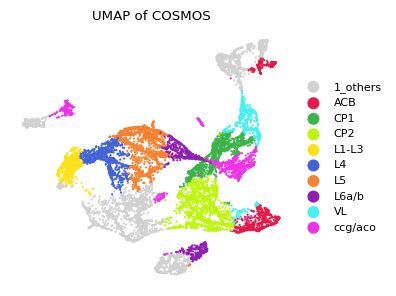

In [6]:
# UMAP visualization
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30)
umap_pos = umap_2d.fit_transform(df_embedding)
adata_new.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_new.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

# Ploting figures
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sz = 10
domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color_1[:num_celltype])
titles = 'UMAP of COSMOS'
ax=sc.pl.scatter(adata_new,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color_1,show=False,size=sz,ax = axes)
ax.axis('off')
plt.tight_layout()


### Pseudo-spatiotemporal map (pSM) from COSMOS integration


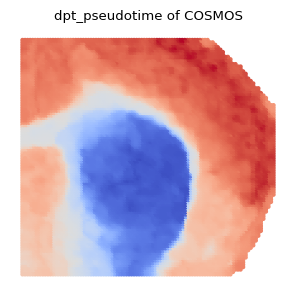

In [7]:

# Calculating pseudo-times 
embedding_adata.uns['iroot'] = np.flatnonzero(adata_new.obs["Cluster_cosmos"] == 'CP2')[0]
sc.tl.diffmap(embedding_adata)
sc.tl.dpt(embedding_adata)
pSM_values_cosmos = embedding_adata.obs['dpt_pseudotime'].to_numpy()


# Ploting figures
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 1, figsize=(3,3))
sz = 10
x = np.array(adata_new.obs['x_pos'])
y = np.array(adata_new.obs['y_pos'])
ax_temp = axes
im = ax_temp.scatter(x, y, s=20, c=pSM_values_cosmos, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('dpt_pseudotime of COSMOS')
plt.tight_layout()


### Showing modality weights of two omics in COSMOS integration

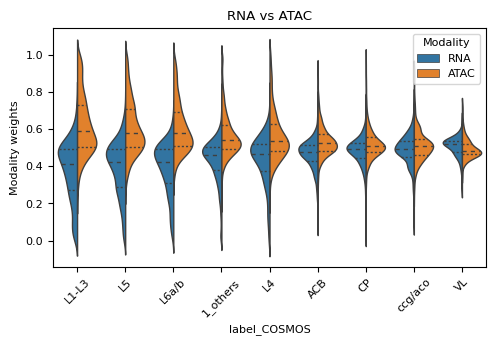

In [8]:
def plot_weight_value(alpha, label, modality1='RNA', modality2='ATAC',order = None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Modality weights']
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(5,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Modality weights', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False, orient = 'v', order=order)
    plt.tight_layout(w_pad=0.05)
    ax.set_title(modality1 + ' vs ' + modality2)
    ax.set_xticklabels(order, rotation = 45)
ordered_cluster = np.unique(LayerName)
layer_type = ordered_cluster
index_all = [np.array([i for i in range(len(LayerName)) if LayerName[i] == ordered_cluster[0]])]
for k in range(1,len(layer_type)):
    temp_idx = np.array([i for i in range(len(LayerName)) if LayerName[i] == ordered_cluster[k]])
    index_all.append(temp_idx)
    
wghts_mean = np.mean(weights[index_all[0],:],0)
for k in range(1,len(ordered_cluster)):
    wghts_mean_temp = np.mean(weights[index_all[k],:],0)
    wghts_mean = np.vstack([wghts_mean, wghts_mean_temp])
df_wghts_mean = pd.DataFrame(wghts_mean,columns = ['w1','w2'],index = ordered_cluster)

df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(weights, np.array(adata_new.obs['LayerName']), order = list(df_sort_mean.index))
